In [1]:
import sys
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import numpy as np

from IPython.display import clear_output

from deps.common_py.dataIO import *
from deps.common_py.evaluationBS import *
from deps.common_py.utils import *
from deps.function.arithdis import *
from deps.ADNNet_data_plus import *
from deps.bayesian.bayesian import bayesRefine_iterative_gpu
from deps.binarymask.binarymask import getTrainBinMask
from deps.params_input.params_input import QParams
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


/home/gfdong/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Temporal Information-Based Classification with DIDL and Updated ADNN Layer

In [2]:
class GaussianBlurConv(nn.Module):
    """
    This class implements a Gaussian Blur as a convolutional operation using a fixed kernel,
    designed to be applied on images. It extends the `nn.Module` class from PyTorch,
    allowing it to be integrated into a neural network as a layer.

    The Gaussian Blur is applied using a predefined kernel that approximates the Gaussian distribution.
    This kernel is applied to each channel of the input image separately, preserving the number of channels.

    Parameters:
    - channels (int): The number of channels in the input images. Defaults to 3 for RGB images.

    The convolution uses 'padding=2' to ensure the output image has the same height and width as the input image.
    """

    def __init__(self, channels=3):
        """
        Initializes the GaussianBlurConv layer.

        Parameters:
        - channels (int): The number of input channels (e.g., 3 for RGB images).
        """
        super(GaussianBlurConv, self).__init__()
        self.channels = channels

        # Define a 5x5 Gaussian kernel.
        kernel = [[0.00078633, 0.00655965, 0.01330373, 0.00655965, 0.00078633],
                  [0.00655965, 0.05472157, 0.11098164, 0.05472157, 0.00655965],
                  [0.01330373, 0.11098164, 0.22508352, 0.11098164, 0.01330373],
                  [0.00655965, 0.05472157, 0.11098164, 0.05472157, 0.00655965],
                  [0.00078633, 0.00655965, 0.01330373, 0.00655965, 0.00078633]]

        # Convert the kernel to a FloatTensor and reshape to fit the conv2d operation.
        kernel = torch.FloatTensor(kernel).unsqueeze(0).unsqueeze(0)  # Reshape to (1, 1, H, W)
        
        # Expand the kernel across the channel dimension to apply the same kernel to each channel.
        kernel = kernel.expand((int(channels), 1, 5, 5))

        # Register the kernel as a non-trainable parameter of the model.
        self.weight = nn.Parameter(data=kernel, requires_grad=False)

    def __call__(self, x):
        """
        Applies the Gaussian Blur to the input image tensor.

        Parameters:
        - x (Tensor): The input image tensor of shape (batch_size, channels, height, width).

        Returns:
        - Tensor: The blurred image tensor of the same shape as the input.
        """
        # Apply the convolution operation with the Gaussian kernel.
        # Use padding to maintain the same image size and specify groups to apply the kernel to each channel separately.
        x = F.conv2d(x, self.weight, padding=2, groups=self.channels)
        return x


def batchConvImgs(imgs, conv=GaussianBlurConv()):
    """
    Applies a convolution operation to each image in a batch.

    This function iterates over a batch of images and applies a specified convolutional operation to each image. The operation is assumed to be an instance of a convolutional layer that expects input of the shape (batch_size, channels, height, width) and returns output of the same shape. Before applying the convolution, the function adjusts the shape of each image to match this expectation and then reshapes the output back to its original form.

    Parameters:
    - imgs (numpy.ndarray or torch.Tensor): A batch of images with shape (frames, row, column, byte), where 'frames' is the number of images, 'row' and 'column' are the dimensions of each image, and 'byte' is the number of channels per pixel.
    - conv (nn.Module): An instance of a PyTorch convolutional layer (or similar) to be applied to each image. Defaults to GaussianBlurConv(), a predefined Gaussian Blur convolution.

    Returns:
    - numpy.ndarray or torch.Tensor: The batch of images after applying the specified convolutional operation, with the same shape as the input.
    """
    
    # Extract the dimensions of the input image batch.
    frames_im, row_im, column_im, byte_im = imgs.shape

    # Iterate over each image in the batch.
    for i in range(frames_im):
        # Reshape the image from (row, column, byte) to (1, byte, row, column) to match
        # the expected input shape for the convolutional layer. This involves adding a
        # batch dimension (unsqueeze) and permuting the dimensions.
        image = imgs[i, :, :, :].unsqueeze(dim=0).permute(0, 3, 1, 2)

        # Apply the convolutional operation to the reshaped image.
        conv_image = conv(image)

        # Reshape the convolved image back to its original shape (row, column, byte)
        # by removing the batch dimension (squeeze) and permuting the dimensions back.
        imgs[i] = conv_image.squeeze().permute(1, 2, 0)

    # Return the batch of images with the convolutional operation applied.
    return imgs


def getVidHist_plus(imgs, left=-1, right=1, border=0.01):
    """
    Computes histograms for each pixel across all frames and channels of a batch of images.

    This function reshapes and permutes the input batch of images to compute histograms
    for each color channel of each pixel across all frames. It allows for specifying the
    range of values and the bin width (border) for the histograms. The histograms are normalized
    by the number of frames, providing a distribution of pixel values across the batch.

    Parameters:
    - imgs (torch.Tensor): A tensor representing a batch of images with shape (frame, row, column, byte),
      where 'frame' is the number of images, 'row' and 'column' are the image dimensions, and 'byte'
      is the number of channels (e.g., 3 for RGB).
    - left (float): The lower bound of the histogram range. Defaults to -1.
    - right (float): The upper bound of the histogram range. Defaults to 1.
    - border (float): The width of each histogram bin. Defaults to 0.01.

    Returns:
    - torch.Tensor: A tensor containing the histograms for each pixel and channel with shape
      (row*column, num_bins, byte), where 'num_bins' is the number of histogram bins determined
      by the range and bin width.
    """
    
    # Unpack the dimensions of the input batch of images.
    frame, row, column, byte = imgs.shape
    
    # Reshape and permute the images to have shape (row*column, frame, byte), which
    # facilitates computing histograms for each pixel location across all frames.
    imgs = imgs.reshape(frame, row*column, byte)
    imgs = imgs.permute(1, 0, 2)
    
    # Calculate the number of bins for the histograms based on the specified range and bin width.
    len_hist = round((right - left) / border) + 1
    
    # Initialize an empty tensor to store the histogram data for each pixel and channel.
    hist_data = torch.empty([row*column, len_hist, byte])
    
    # Compute histograms for each pixel location across all frames and for each channel.
    for i in range(row*column):
        for b in range(byte):
            # Normalize pixel values to the range [left, right] and compute the histogram
            # for the current pixel location and channel. The histogram counts are normalized
            # by the number of frames to obtain a distribution.
            hist_data[i, :, b] = torch.histc((imgs[i, :, b] / 255.0) * right, len_hist, left, right) / (frame * 1.0)
    
    # Return the computed histograms.
    return hist_data


def getNormalData_byHistVid_files(vid_hist, pa_im, ft_im, pa_gt, ft_gt, curidx, left=-1, right=1, delta=0.01):
    """
    Generates normalized data and labels for a specific frame in a video, based on precomputed histograms of video data.

    This function processes a single frame by applying a convolution operation (assuming batchConvImgs is defined to do so),
    normalizing its pixel values, and mapping these values to their corresponding histogram bins. Additionally, it reads the
    ground truth image for the frame and prepares the label data. The function is useful for tasks that require normalized
    feature representations along with corresponding labels, such as supervised learning tasks in computer vision.

    Parameters:
    - vid_hist (torch.Tensor): A tensor containing the histograms for each pixel and channel across all frames of the video.
    - pa_im (str): The path to the directory containing the video frames.
    - ft_im (str): The file type or extension of the video frames.
    - pa_gt (str): The path to the directory containing the ground truth images.
    - ft_gt (str): The file type or extension of the ground truth images.
    - curidx (int): The index of the current frame to process.
    - left (float): The lower bound of the normalized value range. Defaults to -1.
    - right (float): The upper bound of the normalized value range. Defaults to 1.
    - delta (float): The bin width for normalization. Defaults to 0.01.

    Returns:
    - hist_data (torch.Tensor): A tensor of the same shape as vid_hist, containing normalized histogram data for the current frame.
    - labs_data (torch.Tensor): A tensor containing the labels for each pixel in the current frame, reshaped to a 1D array.
    """
    
    # Get the size of the video frames.
    frames, row_im, column_im, byte_im = getVideoSize(pa_im, ft_im)

    # Read the current frame and apply the convolution operation.
    im = readImg_byFilesIdx_pytorch(curidx, pa_im, ft_im)
    im = batchConvImgs(im.unsqueeze(0)).squeeze()
    im = im.reshape(row_im*column_im, byte_im)

    # Read the ground truth image for the current frame.
    lb = readImg_byFilesIdx_pytorch(curidx, pa_gt, ft_gt)

    # Normalize the image pixel values and map them to histogram bins.
    im = (im / 255.0) * right
    im = torch.round(im / delta)

    # Compute the number of bins and offsets for histogram mapping.
    num_hist = round((right - left) / delta) + 1
    num_right = round(right / delta) + 1
    offset_right = round(right / delta)

    # Initialize histogram data tensor.
    hist_data = torch.abs(vid_hist - vid_hist)  # Creates a tensor of zeros with the same shape as vid_hist.
    labs_data = lb.reshape(row_im * column_im)  # Reshape label data to a 1D array.

    # Map normalized pixel values to their corresponding histogram bins.
    for i in range(num_right):
        for b in range(byte_im):
            idx_r = im[:, b] == i
            hist_data[idx_r, (num_hist - offset_right - i):(num_hist - i), b] = vid_hist[idx_r, (num_hist - offset_right):num_hist, b]

    return hist_data, labs_data


class ClassifyNetwork(nn.Module):
    """
    A convolutional neural network (CNN) for classifying images into a fixed number of categories.

    The network consists of a single convolutional layer followed by two fully connected (linear) layers.
    The convolutional layer is designed to process 3-channel (RGB) images. The model applies a ReLU
    activation function after the first fully connected layer and uses a log softmax activation function
    on the output layer to provide log probabilities of each class.

    Attributes:
    - conv1 (nn.Conv2d): The first convolutional layer with 3 input channels, 1 output channel, and a kernel size of (1, 8).
    - fc1 (nn.Linear): The first fully connected layer that maps the flattened output of the convolutional layer to 512 features.
    - fc2 (nn.Linear): The second fully connected layer that maps the 512 features to the number of target classes (3 in this case).

    Parameters:
    - dis_num (int): The number of classes to classify. This parameter is currently unused in the initializer.
    """

    def __init__(self, dis_num):
        super().__init__()
        
        # Initialize the convolutional layer with specific parameters.
        self.conv1 = nn.Conv2d(3, 1, (1, 8), stride=1, bias=False)

        # Initialize the first fully connected layer.
        self.fc1 = nn.Linear(202, 512)
        
        # Initialize the second fully connected layer.
        self.fc2 = nn.Linear(512, 3)

    def forward(self, data):
        """
        Defines the forward pass of the network.

        Parameters:
        - data (torch.Tensor): The input data (images) to the network. Expected shape is (batch_size, 3, height, width),
          where 3 represents the RGB channels.

        Returns:
        - torch.Tensor: The log softmax probabilities of the input data belonging to each class. The shape of the output
          tensor is (batch_size, num_classes), where num_classes is 3 in this implementation.
        """

        # Apply the first convolutional layer.
        x = self.conv1(data)

        # Flatten the output for the linear layer.
        x = x.view(-1, 202)

        # Apply the first fully connected layer and ReLU activation function.
        x = self.fc1(x)
        x = F.relu(x)

        # Apply the second fully connected layer.
        x = self.fc2(x)

        # Apply the log softmax activation function on the output layer to obtain log probabilities.
        return F.log_softmax(x, dim=1)


class PreproNetwork(nn.Module):
    """
    A preprocessing neural network module designed for modifying the input data's dimensions and potentially applying convolutional transformations.

    The network is initialized with three convolutional layers intended for processing input data. However, the current implementation of the forward pass does not apply these layers but instead permutes and squeezes the input tensor. This might be a placeholder for a more complex preprocessing routine to be implemented later.

    Attributes:
    - conv1 (nn.Conv2d): First convolutional layer with 9 input channels, 18 output channels, kernel size of 3, stride of 1, padding of 1, and no bias.
    - conv2 (nn.Conv2d): Second convolutional layer with 18 input channels, 32 output channels, kernel size of 3, stride of 1, padding of 1, and no bias.
    - conv3 (nn.Conv2d): Third convolutional layer with 32 input channels, 1 output channel, kernel size of 3, stride of 1, padding of 1, and no bias.
    """

    def __init__(self):
        super().__init__()

        # Define the convolutional layers with specified configurations.
        self.conv1 = nn.Conv2d(9, 18, 3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(18, 32, 3, stride=1, padding=1, bias=False)
        self.conv3 = nn.Conv2d(32, 1, 3, stride=1, padding=1, bias=False)

    def forward(self, data):
        """
        Performs the preprocessing operations on the input data.

        The current implementation only modifies the input tensor's dimensions through permutation and squeezing. 
        Specifically, it permutes the dimensions to rearrange the channel position and then squeezes out one dimension.
        This implementation might be intended as a placeholder, with actual convolutional processing to be added later.

        Parameters:
        - data (torch.Tensor): The input data to be preprocessed, expected to have a shape that includes a batch size, channels, height, and width.

        Returns:
        - torch.Tensor: The preprocessed data after permuting and squeezing operations.
        """
        
        # Permute the dimensions of the input data to rearrange the channel position.
        x = data.permute(0, 2, 3, 1)
        # Squeeze out the specified dimension (in this case, the second dimension).
        x = x.squeeze(1)

        # Note: Convolutional layers defined in the class are not used in the current forward pass.
        return x
        

def detectFg(data_vid, batchsize, device, X, W, B, F_W, F_B, proddis, sumdis, netP, netC):
    """
    Detects the foreground in video data using deep learning models and arithmetic operations.

    This function processes the input video data in batches, applying a series of operations to
    each batch to classify pixels or regions as foreground or background. It leverages a preprocessing
    network, arithmetic operations, and a classification network to achieve this.

    Parameters:
    - data_vid (torch.Tensor): The input video data as a tensor, with shape (frames, channels, height, width).
    - batchsize (int): The size of each batch to process the video data.
    - device (torch.device): The device (CPU or GPU) to perform computations on.
    - X (object): An object or structure to hold intermediate data.
    - W, B (torch.Tensor): Tensors representing weights or parameters for the arithmetic operations on foreground.
    - F_W, F_B (function): Functions representing the arithmetic operations to be applied using W and B, respectively.
    - proddis, sumdis (function): Functions to compute the arithmetic distance for W and B.
    - netP (torch.nn.Module): A PyTorch model for preprocessing the input data.
    - netC (torch.nn.Module): A PyTorch model for classifying the processed data as foreground or background.

    Returns:
    - numpy.ndarray: An array containing the foreground detection labels for each frame of the input video data.

    The function processes the video data in specified batch sizes, applying preprocessing, arithmetic
    operations based on the provided functions and tensors, and finally classifying the output to detect
    foreground. The classification results for each batch are collected and returned as a NumPy array.
    """
    
    # Initialize an array to hold the labels (foreground/background) for each frame.
    re_labs = np.zeros(data_vid.shape[0])

    # Process the video data without computing gradients for efficiency.
    with torch.no_grad():
        # Iterate over the video data in batches.
        for i in range(round(data_vid.shape[0]/batchsize + 0.499999999999999999)):
            # Extract the current batch and move it to the specified device.
            data = data_vid[i*batchsize:(i + 1)*batchsize].to(device, dtype=torch.float32)

            # Apply the preprocessing network to the current batch.
            X._f = netP(data)

            # Perform the arithmetic operations for foreground and background detection.
            output_W = arithmeticDis(X, W, F_W, proddis)
            output_B = arithmeticDis(X, B, F_B, sumdis)

            # Combine the outputs from the arithmetic operations.
            output_DIS = (output_W._f + output_B._f)
            
            # Classify the combined output to detect foreground.
            output_labs = netC(output_DIS)
            
            # Store the classification results in the results array.
            re_labs[i*batchsize:(i + 1)*batchsize] = output_labs.argmax(dim=1, keepdim=True).cpu().detach().squeeze()

    return re_labs

In [3]:
# Initialize CUDA settings
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("------------\n{}\n------------".format(use_cuda))

# Configuration parameters
batch_size = 1000  # Unified naming convention
left_data, right_data = -1, 1  # Compact variable assignment
left, right, delta, lr_rate = -1, 1, 0.01, 0.0001
num_dis, chls = 8, 3  # Number of distributions and channels
name = 'highway'  # Dataset name

X = PDFs().emptyPDFs(7, chls, left, right - delta, delta)
W, B, F_W, F_B = [PDFs().emptyPDFs(num_dis, chls, left, right, delta) for _ in range(4)]

# Operations on distributions
proddis, sumdis = ProdDis.apply, SumDis.apply  # Function aliases for clarity

# Move tensors to the specified device
tensors = [X, W, B, F_W, F_B]
for tensor in tensors:
    tensor.to(device)

# Preprocess PDFs and distributions
for pdf in [X, W, B, F_W, F_B]:
    preProcessPDF(pdf)
preProdDis(X, W, F_W)
preSumDis(X, B, F_B)

# Enable gradient computation for optimization
W._f = Variable(W._f, requires_grad = True)
B._f = Variable(B._f, requires_grad = True)

# Load networks and their weights
netC = ClassifyNetwork(num_dis).to(device)
netP = PreproNetwork().to(device)

name_netC = './models/netC_0069.pt'
name_netP = './models/netP_0069.pt'

name_f_W = './models/f_W_0069.pt'
name_f_B = './models/f_B_0069.pt'

netC.load_state_dict(torch.load(name_netC, map_location = device))
netP.load_state_dict(torch.load(name_netP, map_location = device))

W._f = torch.load(name_f_W, map_location = device)
B._f = torch.load(name_f_B, map_location = device)

# Load and preprocess images
print("loading test data")
path_config = {
    'im': ('jpg', f'./data/{name}/input/'),
    'gt': ('png', f'./data/{name}/groundtruth/'),
    'out': f'./output/{name}/DIDL/'
}


imgs = loadImgs_pytorch(path_config['im'][1], path_config['im'][0])
print(f"Original images shape: {imgs.shape}")
if imgs.ndim == 3: 
    imgs = imgs.unsqueeze(3).repeat(1, 1, 1, 3)
imgs = gaussianSmooth(imgs)  
eximgs = videoPadding(imgs, radius=0)

data_normalized = eximgs.clone() / 255.0
c_X, hists_tensor_sp = tensor2hist(data_normalized, dim=0)
print("Preprocessing completed.")

frames, row_im, column_im, byte_im = imgs.shape

print("Removing original images from memory to free up space.")
del imgs 
print("Memory cleanup completed.")
fs, fullfs = loadFiles_plus(path_config['gt'][1], path_config['gt'][0])


# Evaluate performance on the dataset
TP_sum, FP_sum, TN_sum, FN_sum = 0, 0, 0, 0

for frame_idx in range(frames): 
    str_out = f"Processing frame {frame_idx + 1}/{frames}...\n"

    check_filename = os.path.join(path_config['out'], fs[frame_idx])
    labs_tru = readImg_byFilesIdx_pytorch(frame_idx, path_config['gt'][1], path_config['gt'][0])

    if torch.sum(labs_tru == 255) + torch.sum(labs_tru == 0) == 0:
        str_out += f"Empty groundtruth frame: frame_idx = {frame_idx}\n"
        continue

    if not os.path.exists(check_filename):
        data = eximgs[frame_idx] / 255.0
        subhist_sp = getSubHists_byHist(data, hists_tensor_sp)

        size = subhist_sp.shape
        subhist_sp = subhist_sp.reshape(size[0], size[1]*size[2], size[3]*size[4], size[5]).permute(1, 0, 2, 3)

        re_labs = detectFg(subhist_sp, batch_size, device, X, W, B, F_W, F_B, proddis, sumdis, netP, netC) / 2
        im_fg = np.round(re_labs.reshape(row_im, column_im) * 255)
    else:
        im_fg = imageio.imread(check_filename)

    labs_tru = readImg_byFilesIdx_pytorch(frame_idx, path_config['gt'][1], path_config['gt'][0]).numpy()
    gt_fg = np.round(labs_tru)

    TP, FP, TN, FN = evaluation_numpy_entry_torch(torch.tensor(im_fg), torch.tensor(gt_fg))

    TP_sum += TP
    FP_sum += FP
    TN_sum += TN
    FN_sum += FN

    Re = TP / max(TP + FN, 1)
    Pr = TP / max(TP + FP, 1)
    Fm = 2 * Pr * Re / max(Pr + Re, 0.0001)

    str_out += f"Frame {frame_idx}: Re={Re:.3f}, Pr={Pr:.3f}, Fm={Fm:.3f}"
    filename = path_config['out'] + fs[frame_idx]
    saveImg(filename, im_fg.astype(np.uint8))
    clear_output(wait=True)
    print(str_out)


Re_acc = TP_sum / max(TP_sum + FN_sum, 1)
Pr_acc = TP_sum / max(TP_sum + FP_sum, 1)
Fm_acc = 2 * Pr_acc * Re_acc / max(Pr_acc + Re_acc, 0.0001)

print(f"\nAccumulated Metrics:\nRe_acc={Re_acc:.3f}, Pr_acc={Pr_acc:.3f}, Fm_acc={Fm_acc:.3f}")


Processing frame 1700/1700...
Frame 1699: Re=0.924, Pr=0.994, Fm=0.958

Accumulated Metrics:
Re_acc=0.921, Pr_acc=0.997, Fm_acc=0.957


# Spatial Correlation with SBR Network

In [4]:
class OutConv(nn.Module):
    """
    A PyTorch module for applying a 2D convolution operation with a kernel size of 1.
    
    This module is typically used to change the number of channels in the input tensor
    without affecting its height and width, making it suitable for tasks like channel
    transformation at the end of a CNN architecture.

    Parameters:
    - in_channels (int): The number of channels in the input tensor.
    - out_channels (int): The desired number of channels in the output tensor.
    
    Attributes:
    - conv (nn.Conv2d): The convolutional layer that performs the actual channel
      transformation operation.
    """

    def __init__(self, in_channels, out_channels):
        """
        Initializes the OutConv module with a convolutional layer.
        
        Parameters:
        - in_channels (int): The number of channels in the input tensor.
        - out_channels (int): The desired number of channels in the output tensor.
        """
        super(OutConv, self).__init__()  # Initialize the parent class (nn.Module)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        # A convolutional layer with kernel_size=1 is used for channel-wise transformation.

    def forward(self, x):
        """
        Defines the forward pass of the module.
        
        Parameters:
        - x (Tensor): The input tensor with shape (batch_size, in_channels, H, W).
        
        Returns:
        - Tensor: The output tensor after applying the 2D convolution, with shape
          (batch_size, out_channels, H, W).
        """
        return self.conv(x)  # Apply the convolutional layer to the input tensor and return the result.


class DoubleConv(nn.Module):
    """
    A PyTorch module implementing a double convolutional block where each convolution 
    operation is followed by a Batch Normalization (BN) and a ReLU activation function. 
    This sequence is repeated twice.

    The block structure is: (Convolution => ReLU) * 2

    Parameters:
    - in_channels (int): Number of channels in the input tensor.
    - out_channels (int): Number of channels in the output tensor after the second convolution.
    - mid_channels (int, optional): Number of channels after the first convolution. If not
      specified, it defaults to the value of out_channels.

    Attributes:
    - double_conv (nn.Sequential): Sequential container of the two convolutional operations 
      each followed by a ReLU activation function.
    """

    def __init__(self, in_channels, out_channels, mid_channels=None):
        """
        Initializes the DoubleConv module with the specified number of input, mid, and 
        output channels. If mid_channels is not provided, it is set to the same value as 
        out_channels by default.

        Parameters:
        - in_channels (int): Number of channels in the input tensor.
        - out_channels (int): Number of channels in the output tensor after the second convolution.
        - mid_channels (int, optional): Number of channels after the first convolution. Defaults to
          out_channels if not specified.
        """
        super().__init__()
        if not mid_channels:  # Check if mid_channels is provided, otherwise set it to out_channels
            mid_channels = out_channels

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
        )

    def forward(self, x):
        """
        Defines the forward pass of the DoubleConv module.

        Parameters:
        - x (Tensor): The input tensor with shape (batch_size, in_channels, H, W).

        Returns:
        - Tensor: The output tensor after processing through two convolutional operations,
          each followed by a ReLU activation, with shape (batch_size, out_channels, H, W).
        """
        return self.double_conv(x)

class Down(nn.Module):
    """
    A PyTorch module that performs downscaling on an input tensor using max pooling followed by 
    a double convolution block. This module is typically used in CNN architectures to reduce the 
    spatial dimensions of the input tensor while increasing the depth (number of channels), 
    allowing the model to capture more complex features at a lower resolution.

    Parameters:
    - in_channels (int): Number of channels in the input tensor.
    - out_channels (int): Number of channels in the output tensor after the double convolution.

    Attributes:
    - maxpool_conv (nn.Sequential): A sequential container that first applies max pooling to 
      downscale the input tensor and then performs a double convolution operation.
    """

    def __init__(self, in_channels, out_channels):
        """
        Initializes the Down module with max pooling for downscaling followed by a double 
        convolution block for feature extraction at the reduced resolution.

        Parameters:
        - in_channels (int): Number of channels in the input tensor.
        - out_channels (int): Number of channels in the output tensor after the double convolution.
        """
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),  # Max pooling with a kernel size of 2 for downscaling
            DoubleConv(in_channels, out_channels)  # Double convolution block
        )

    def forward(self, x):
        """
        Defines the forward pass through the Down module.

        Parameters:
        - x (Tensor): The input tensor with shape (batch_size, in_channels, H, W).

        Returns:
        - Tensor: The output tensor after downscaling and double convolution, with reduced spatial 
          dimensions and potentially increased number of channels, depending on out_channels. The 
          shape is (batch_size, out_channels, H/2, W/2) assuming the input height and width are 
          divisible by 2.
        """
        return self.maxpool_conv(x)

class Up(nn.Module):
    """
    A PyTorch module for upscaling the spatial dimensions of an input tensor followed by 
    a double convolution operation. The module supports bilinear upsampling or transposed
    convolution for upscaling. This is typically used in the decoder part of segmentation 
    networks to increase the resolution of feature maps.

    Parameters:
    - in_channels (int): Number of channels in the input tensor before upscaling.
    - out_channels (int): Number of channels in the output tensor after double convolution.
    - bilinear (bool): If True, use bilinear interpolation for upsampling. Otherwise, 
      use transposed convolution. Defaults to True.
    - ext (bool): Experimental flag for altering input channels before double convolution.
      Defaults to False.

    Attributes:
    - up (nn.Module): The upsampling module, either nn.Upsample for bilinear interpolation
      or nn.ConvTranspose2d for transposed convolution.
    - conv (DoubleConv): The double convolution module applied after upsampling.
    """

    def __init__(self, in_channels, out_channels, bilinear=True, ext=False):
        super().__init__()

        # Upsampling strategy
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # For bilinear upsampling, adjust channels after upsampling
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            # For transposed convolution, no channel adjustment needed before double conv
            self.up = nn.ConvTranspose2d(in_channels // 2,
                                         in_channels // 2,
                                         kernel_size=2,
                                         stride=2)
            if ext:
                # Experimental feature to adjust in_channels
                in_channels = 20
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        """
        Forward pass for combining two feature maps with upscaling.

        Parameters:
        - x1 (Tensor): The tensor to be upscaled.
        - x2 (Tensor): The tensor to be concatenated with the upscaled x1.

        Returns:
        - Tensor: The result of upscaling x1, concatenating it with x2, and passing
          the combined tensor through a double convolution.
        """
        x1 = self.up(x1)  # Upscale x1

        # Ensure the dimensions match for concatenation
        if x1.shape[3] != x2.shape[3]:
            x1 = F.pad(x1, (0, 1))
        if x1.shape[2] != x2.shape[2]:
            x1 = F.pad(x1, (0, 0, 1, 0))
        
        x = torch.cat([x2, x1], dim=1)  # Concatenate x1 and x2 along the channel dimension
        return self.conv(x)  # Pass through double convolution


class U_Net(nn.Module):
    """
    Implements the U-Net architecture for semantic segmentation. U-Net is characterized by its
    encoder-decoder structure with skip connections, enabling precise localization. This class
    allows for customization of the number of channels in the input and output, as well as the 
    choice between bilinear upsampling and transposed convolutions for upscaling in the decoder.

    Parameters:
    - n_channels (int): Number of channels in the input images.
    - n_classes (int): Number of output classes for segmentation.
    - bilinear (bool): If True, use bilinear upsampling for the decoder path. Otherwise, use 
      transposed convolutions.

    Attributes:
    - Each encoder (down) and decoder (up) step is implemented as a separate module, allowing 
      for modular composition of the network. The final layer is a convolution that maps the 
      features to the prediction space of `n_classes`.
    """
    
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(U_Net, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Base number of channels for the U-Net architecture
        u_net_base_channels = 16

        # Encoder (downsampling path)
        self.unet_encode = DoubleConv(n_channels, u_net_base_channels)
        self.down1 = Down(u_net_base_channels, u_net_base_channels * 2)
        self.down2 = Down(u_net_base_channels * 2, u_net_base_channels * 4)
        self.down3 = Down(u_net_base_channels * 4, u_net_base_channels * 4)

        # Decoder (upsampling path)
        self.up1 = Up(u_net_base_channels * 8, u_net_base_channels * 2, bilinear)
        self.up2 = Up(u_net_base_channels * 4, u_net_base_channels, bilinear)
        self.up3 = Up(u_net_base_channels * 2, u_net_base_channels, bilinear)

        # Final output layer
        self.outc1 = OutConv(u_net_base_channels, n_classes)

    def forward(self, x):
        """
        Defines the forward pass through the U-Net model.
        
        Parameters:
        - x (Tensor): The input tensor of shape (batch_size, n_channels, H, W).
        
        Returns:
        - Tensor: The output segmentation map of shape (batch_size, n_classes, H, W).
        """

        # Encoder path
        x1 = self.unet_encode(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)

        # Decoder path with skip connections
        x_u = self.up1(x4, x3)
        x_u = self.up2(x_u, x2)
        x_u = self.up3(x_u, x1)

        # Final convolution to get the segmentation map
        logits = self.outc1(x_u)
        return logits
        
def detect_current_level(img_patch_bags, gt_patch_bags, original_centers,
                         network, len_batch, current_radius, original_gt):
    """
    Detects the current level's mask by processing image patches through a trained network
    and aggregating predictions to form a comprehensive mask aligned with the original
    image's dimensions.

    Parameters:
    - img_patch_bags (Tensor): A 4D tensor of image patches with shape [num_patches, 4, patch_size, patch_size].
    - gt_patch_bags (Tensor): A 4D tensor of ground truth patches, not used in the current implementation but
                              included for potential future extensions.
    - original_centers (list of lists): A 2D list containing the original center positions of each patch.
    - network (nn.Module): The trained network model for processing image patches.
    - len_batch (int): The batch size for processing patches through the network.
    - current_radius (int): The radius of the current level, used for adjusting the mask's placement.
    - original_gt (Tensor): The original ground truth 2D tensor, used for initializing the size of the refined mask.

    Returns:
    - refined_mask (Tensor): The aggregated and refined mask aligned with the original image's dimensions.
    - sampled_mask (Tensor): A mask indicating the sampling density across the original image's dimensions.
    """
    NUM_DATA = img_patch_bags.shape[0]
    NUM_BATCH = round(NUM_DATA / len_batch - 0.5)  # Compute the number of batches

    # Normalize image patches and transfer to CUDA
    imgs = img_patch_bags.to("cuda", dtype=torch.float32) / 255.0

    # Process the first batch outside the loop to initialize re_mask
    imgs_batch = imgs[:len_batch]
    with torch.no_grad():
        re_mask = network(imgs_batch)

    # Process remaining batches
    for batch_start in range(len_batch, NUM_DATA, len_batch):
        imgs_batch = imgs[batch_start:batch_start + len_batch]
        with torch.no_grad():
            mask = network(imgs_batch)
        re_mask = torch.cat((re_mask, mask), dim=0)

    re_mask = re_mask.argmax(dim=1, keepdim=True).squeeze()

    # Initialize buffers for refined and sampled masks, adjust for CUDA
    refined_mask = torch.zeros(original_gt.shape, dtype=torch.int64).cuda()
    sampled_mask = torch.zeros(original_gt.shape, dtype=torch.int64).cuda()

    # Padding to handle edge cases near borders
    pad = transforms.Pad(current_radius, padding_mode='reflect')
    refined_mask, sampled_mask = [pad(mask.unsqueeze(0)).squeeze(0) for mask in (refined_mask, sampled_mask)]
    
    # Aggregate predictions over original image dimensions
    for idx, (x, y) in enumerate(original_centers):
        x, y = [pos + current_radius for pos in (x, y)]
        slice_ = (slice(x - current_radius, x + current_radius), slice(y - current_radius, y + current_radius))
        refined_mask[slice_] += re_mask[idx]
        sampled_mask[slice_] += 1

    # Remove padding to match the original image dimensions
    refined_mask, sampled_mask = [mask[current_radius:-current_radius, current_radius:-current_radius] for mask in (refined_mask, sampled_mask)]

    return refined_mask, sampled_mask

def cut_patches_randomly(imXfg, img, gt, num_pos, radius):
    """
    Extracts random patches from an image, its ground truth (GT), and a foreground indication tensor.

    Parameters:
    - imXfg (Tensor): A 2D tensor indicating the foreground areas of the image, of shape (row_im, column_im).
    - img (Tensor): The input image tensor of shape (row_im, column_im, channel).
    - gt (Tensor): The ground truth tensor for the image, of shape (row_im, column_im).
    - num_pos (int): The number of patches to extract.
    - radius (int): The radius of each patch. The diameter of patches will be 2*radius.

    Returns:
    - img_patch_bags (Tensor): A tensor containing the image patches of shape (num_pos, 3, 2*radius, 2*radius).
    - gt_patch_bags (Tensor): A tensor containing the GT patches of shape (num_pos, 2*radius, 2*radius).
    - imXfg_patch_bags (Tensor): A tensor containing the foreground patches of shape (num_pos, 2*radius, 2*radius).
    - original_centers (list): A list of the original center coordinates of each patch.
    """
    # Add an extra dimension to imXfg and gt and convert to float
    imXfg, gt = [x.unsqueeze(0).float() for x in (imXfg, gt)]

    # Reorder img to channel-first format and convert to float
    img = img.permute(2, 0, 1).float()

    # Apply padding to tensors
    pad = transforms.Pad(radius, padding_mode='reflect')
    img_pad, gt_pad, imXfg_pad = [pad(x) for x in (img, gt, imXfg)]

    # Transfer tensors to CUDA as integer type
    img_pad, gt_pad, imXfg_pad = [x.int().cuda() for x in (img_pad, gt_pad, imXfg_pad)]

    # Remove the first dimension from gt_pad and imXfg_pad
    gt_pad, imXfg_pad = [x.squeeze(0) for x in (gt_pad, imXfg_pad)]

    # Initialize tensors for storing patches
    img_patch_bags = torch.zeros((num_pos, 3, radius*2, radius*2), dtype=torch.int).cuda()
    gt_patch_bags = torch.zeros((num_pos, radius*2, radius*2), dtype=torch.int).cuda()
    imXfg_patch_bags = torch.zeros((num_pos, radius*2, radius*2), dtype=torch.int).cuda()

    original_centers = []

    for i in range(num_pos):
        # Randomly choose a patch center within valid bounds
        center_x = random.randint(radius, img.shape[1] + radius - 1)
        center_y = random.randint(radius, img.shape[2] + radius - 1)

        # Extract the patch for img, gt, and imXfg
        slice_x = slice(center_x - radius, center_x + radius)
        slice_y = slice(center_y - radius, center_y + radius)
        img_patch_bags[i] = img_pad[:, slice_x, slice_y]
        gt_patch_bags[i] = gt_pad[slice_x, slice_y]
        imXfg_patch_bags[i] = imXfg_pad[slice_x, slice_y]

        # Adjust center coordinates to original image space
        original_centers.append([center_x - radius, center_y - radius])

    return img_patch_bags, gt_patch_bags, imXfg_patch_bags, original_centers

def detectFgImg_random(pa_im, ft_im, pa_fg, ft_fg, pa_gt, ft_gt, idx, network, device, len_batch, layers, radius=[16, 32, 64]):
    """
    Detects the foreground in an image using a network-based approach on randomly extracted patches across multiple scales.

    Parameters:
    - pa_im (str): Path to the directory containing the images.
    - ft_im (str): File type/extension of the images.
    - pa_fg (str): Path to the directory containing the foreground masks.
    - ft_fg (str): File type/extension of the foreground masks.
    - pa_gt (str): Path to the directory containing the ground truth masks.
    - ft_gt (str): File type/extension of the ground truth masks.
    - idx (int): Index of the image to process.
    - network (nn.Module): The neural network model for foreground detection.
    - device (str): The device to run the model on ('cuda' or 'cpu').
    - len_batch (int): Batch size for processing patches through the network.
    - layers (float): Scaling factor to adjust the number of positions based on the radius.
    - radius (list of int): Radii of patches to extract at different scales.

    Returns:
    - hist_mask (numpy.ndarray): Histogram of refined masks normalized by the sampled mask.
    - refinemask (numpy.ndarray): Binary mask obtained by applying a threshold to the hist_mask.
    - fg (Tensor): Foreground indication tensor.
    - gt (Tensor): Ground truth tensor.
    - refine_mask_different_level (list): List of refined masks at different levels.
    """
    # Construct file paths and read image and masks
    input_path, fg_path, gt_path = [f'{path}{prefix}{idx:06}.{ft}' for path, prefix, ft in zip([pa_im, pa_fg, pa_gt], ['in', 'gt', 'gt'], [ft_im, ft_fg, ft_gt])]
    img, fg, gt = [torch.from_numpy(imageio.imread(path)) for path in [input_path, fg_path, gt_path]]

    # Initialize refined and sampled masks
    refined_mask, sampled_mask = [torch.zeros(gt.shape, dtype=torch.int64, device=device) for _ in range(2)]

    refine_mask_different_level = []

    # Process patches at different levels
    for current_radius in radius:
        current_num_pos = int(((img.shape[0] * img.shape[1]) * layers) / ((2 * current_radius) ** 2))
        
        img_patch_bags, gt_patch_bags, imXfg_patch_bags, original_centers = cut_patches_randomly(fg, img, gt, current_num_pos, current_radius)
        
        # Prepare patches for the network
        imXfg_patch_bags = imXfg_patch_bags.unsqueeze(1)
        img_patch_bags = torch.cat((img_patch_bags, imXfg_patch_bags), dim=1).to(device)

        # Detect foreground at current level
        current_refined_mask, current_sampled_mask = detect_current_level(img_patch_bags, gt_patch_bags, original_centers, network, len_batch, current_radius, gt)

        # Accumulate results
        refined_mask += current_refined_mask
        sampled_mask += current_sampled_mask
        refine_mask_different_level.append(current_refined_mask.cpu().numpy())

    # Normalize and threshold the aggregated mask
    hist_mask = (refined_mask / sampled_mask.clamp(min=1)).cpu().numpy()  # Avoid division by zero
    hist_mask[np.isnan(hist_mask)] = 0  # Handle NaNs
    refinemask = hist_mask > 0.5  # Simple thresholding, can be replaced with Otsu's method if needed

    return hist_mask, refinemask, fg.cpu(), gt.cpu(), refine_mask_different_level

def update_metrics(fgim, gtim, rfim, metrics):
    """
    Updates the provided metrics dictionary with True Positives (TP), False Positives (FP),
    True Negatives (TN), and False Negatives (FN) based on the foreground image (fgim),
    ground truth image (gtim), and refined image (rfim).
    """
    TP, FP, TN, FN = evaluation_numpy_entry_torch(fgim, gtim)
    metrics['TP'] += TP
    metrics['FP'] += FP
    metrics['TN'] += TN
    metrics['FN'] += FN

    TP_rf, FP_rf, TN_rf, FN_rf = evaluation_numpy_entry_torch(rfim, gtim)
    metrics['TP_rf'] += TP_rf
    metrics['FP_rf'] += FP_rf
    metrics['TN_rf'] += TN_rf
    metrics['FN_rf'] += FN_rf

def print_cumulative_metrics(metrics):
    """
    Prints the cumulative Recall (Re), Precision (Pr), and F-measure (Fm) for both the original and refined foreground detection.
    """
    Re_sum = metrics['TP'] / max((metrics['TP'] + metrics['FN']), 1)
    Pr_sum = metrics['TP'] / max((metrics['TP'] + metrics['FP']), 1)
    Fm_sum = (2 * Pr_sum * Re_sum) / max((Pr_sum + Re_sum), 0.0001)

    print(f"\nAccumulate original: Re_sum: {Re_sum:4f}, Pr_sum: {Pr_sum:4f}, Fm_sum: {Fm_sum:4f}")

    Re_sum_rf = metrics['TP_rf'] / max((metrics['TP_rf'] + metrics['FN_rf']), 1)
    Pr_sum_rf = metrics['TP_rf'] / max((metrics['TP_rf'] + metrics['FP_rf']), 1)
    Fm_sum_rf = (2 * Pr_sum_rf * Re_sum_rf) / max((Pr_sum_rf + Re_sum_rf), 0.0001)

    print(f"Accumulate refinefg: Re_sum_rf: {Re_sum_rf:4f}, Pr_sum_rf: {Pr_sum_rf:4f}, Fm_sum_rf: {Fm_sum_rf:4f}")

def display_images(imXfg, hist_mask, refinemask, gt):
    """
    Display the foreground, histogram mask, refined mask, and ground truth images side by side.
    
    Parameters:
    - imXfg (Tensor): The foreground image.
    - hist_mask (Tensor): The histogram mask.
    - refinemask (Tensor): The refined mask.
    - gt (Tensor): The ground truth mask.
    """
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    
    axs[0].imshow(imXfg.cpu().numpy(), cmap='gray')
    axs[0].set_title('DIDL Mask')
    axs[0].axis('off')
    
    axs[1].imshow(hist_mask.cpu().numpy(), cmap='gray')
    axs[1].set_title('Histogram Mask')
    axs[1].axis('off')
    
    axs[2].imshow(refinemask.cpu().numpy(), cmap='gray')
    axs[2].set_title('Refined Mask')
    axs[2].axis('off')
    
    axs[3].imshow(gt.cpu().numpy(), cmap='gray')
    axs[3].set_title('Ground Truth')
    axs[3].axis('off')
    
    plt.show()


Accumulate original: Re_sum: 0.920519, Pr_sum: 0.996818, Fm_sum: 0.957150
Accumulate refinefg: Re_sum_rf: 0.991012, Pr_sum_rf: 0.999284, Fm_sum_rf: 0.995131


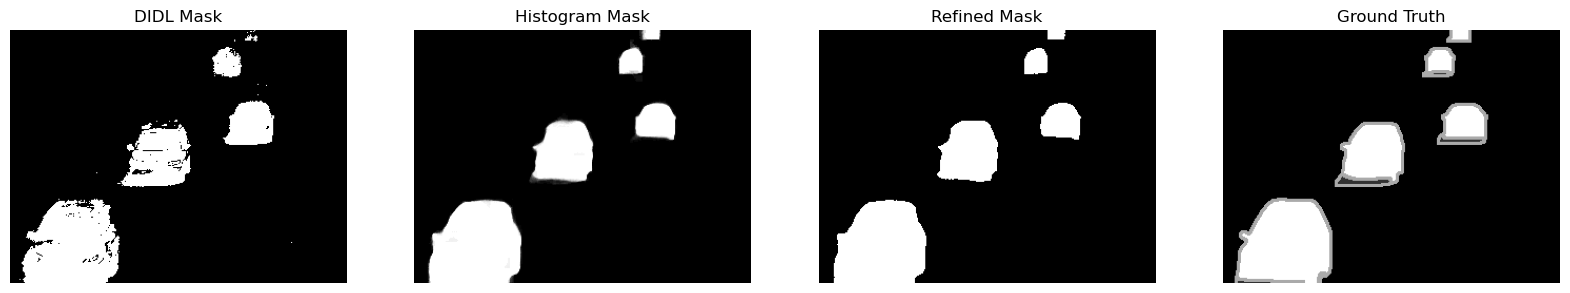

In [5]:
# Setup paths and model
name = 'highway'
path_config = {
    'im': ('jpg', f'./data/{name}/input/'),
    'gt': ('png', f'./data/{name}/groundtruth/'),
    'fg': ('png', f'./output/{name}/DIDL/'),
    'out': ('png', f'./output/{name}/SBR/'),
    'mask': ('png', f'./output/{name}/mask/')
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
network = U_Net(n_channels=4, n_classes=2, bilinear=False).to(device)
network = torch.nn.DataParallel(network)
network.load_state_dict(torch.load('./models/network_dis_0100.pt'))

# Initialize cumulative metrics
cumulative_metrics = {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0, 'TP_rf': 0, 'FP_rf': 0, 'TN_rf': 0, 'FN_rf': 0}

fs, fullfs = loadFiles_plus(path_config['gt'][1], path_config['gt'][0])
frames = len(fullfs)

for i in range(frames):
    print(f"Processing frame: {i+1}/{frames}", end='\r')

    mask_gt_path = fullfs[i]
    mask_gt = torch.tensor(imageio.imread(mask_gt_path), dtype=torch.float)

    # Check if the ground truth mask is valid
    if not (torch.sum(mask_gt == 255) + torch.sum(mask_gt == 0)):
        continue

    hist_mask, refinemask, imXfg, gt, all_refine_mask = detectFgImg_random(
        path_config['im'][1], path_config['im'][0],
        path_config['fg'][1], path_config['fg'][0],
        path_config['gt'][1], path_config['gt'][0],
        i, network, device, 128 * 4, 8
    )
    refinemask, hist_mask = [(torch.tensor(x, dtype=torch.float) * 255).int() for x in (refinemask, hist_mask)]

    # Save the histogram mask
    os.makedirs(path_config['mask'][1], exist_ok=True)
    imageio.imwrite(os.path.join(path_config['mask'][1], f'{i:06}_hist_mask.png'), hist_mask.byte())

    # Evaluate and update metrics
    update_metrics(imXfg.int(), gt.int(), refinemask, cumulative_metrics)
    # Save the refined mask
    os.makedirs(path_config['out'][1], exist_ok=True)
    imageio.imwrite(os.path.join(path_config['out'][1], f'{i:06}_sbr.png'), refinemask.byte())

    # After processing all frames, print the cumulative evaluation metrics
    clear_output(wait=True)
    print_cumulative_metrics(cumulative_metrics)
    display_images(imXfg, hist_mask, refinemask, gt)
